
<h1 style="font-size:5em;color:red;background-color:black;padding:3em 1em;;text-align:center;font-family:mono;font-weight:900;"> 🗯OffensEval 2019🗯<h1>


In [1]:
# boilerplate code provided by keggle

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/olid-dataset/olid-annotation.txt
/kaggle/input/olid-dataset/testset-levela.tsv
/kaggle/input/olid-dataset/olid-training-v1.0.tsv
/kaggle/input/olid-dataset/labels-levelc.csv
/kaggle/input/olid-dataset/README.txt
/kaggle/input/olid-dataset/labels-levelb.csv
/kaggle/input/olid-dataset/testset-levelc.tsv
/kaggle/input/olid-dataset/labels-levela.csv
/kaggle/input/olid-dataset/testset-levelb.tsv


In [2]:
!pip3 install torchsummary

In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.optim import AdamW
import seaborn as sns
from torchsummary import summary
import warnings
warnings.filterwarnings('ignore') 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h1 style="font-size:2em;color:red;background-color:black;padding:1em 1em;;text-align:center;font-family:mono;font-weight:900;"> 📂 Reading Input<h1>

In [4]:
# training data reading
df = pd.read_csv('/kaggle/input/olid-dataset/olid-training-v1.0.tsv',sep='\t')
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


<h1 style="font-size:2em;color:red;background-color:black;padding:1em 1em;;text-align:center;font-family:mono;font-weight:900;"> 🌊 Data Visualization<h1>

<Axes: xlabel='subtask_a', ylabel='count'>

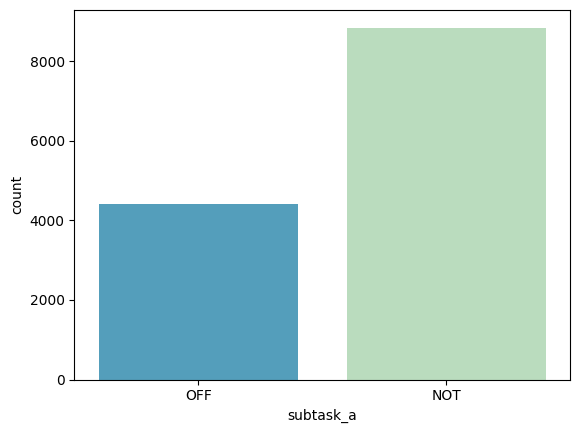

In [5]:
sns.countplot(x='subtask_a',palette='GnBu_r',data=df)

<Axes: xlabel='subtask_b', ylabel='count'>

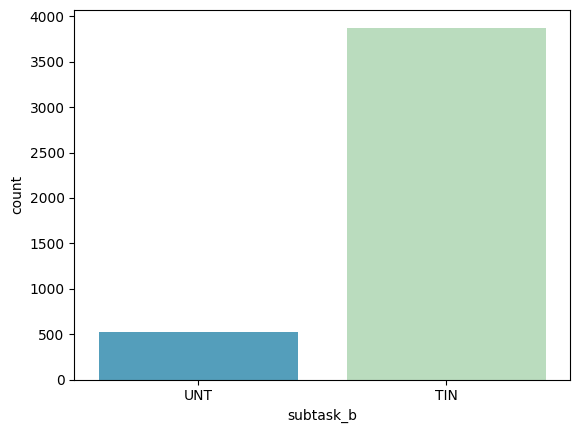

In [6]:
sns.countplot(x='subtask_b',palette='GnBu_r',data=df)

<Axes: xlabel='subtask_c', ylabel='count'>

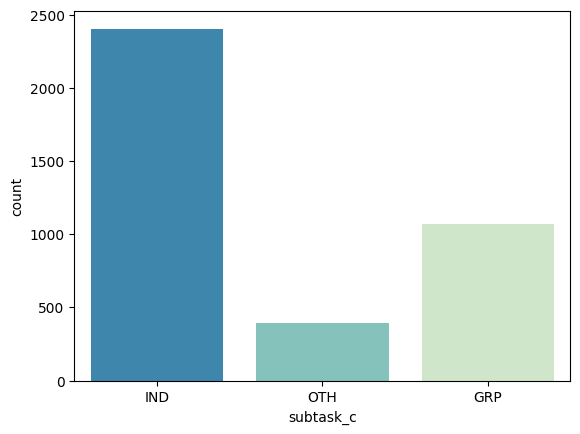

In [7]:
sns.countplot(x='subtask_c',palette='GnBu_r',data=df)

<h1 style="font-size:2em;color:red;background-color:black;padding:1em 1em;;text-align:center;font-family:mono;font-weight:900;"> 🔃 Data Preprocess<h1>

In [8]:
df['label_a'] = df['subtask_a'].replace({'NOT': 0, 'OFF': 1})

<h1 style="font-size:2em;color:red;background-color:black;padding:1em 1em;;text-align:center;font-family:mono;font-weight:900;"> Spliting <h1>

In [9]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
# loading the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# tokenize the input data for feeding the model
train_tokens = tokenizer(list(train_df['tweet']), padding=True, truncation=True, return_tensors='pt', max_length=128)
val_tokens = tokenizer(list(val_df['tweet']), padding=True, truncation=True, return_tensors='pt', max_length=128)

In [12]:
# converting labels to tensors
train_labels = torch.tensor(list(train_df['label_a']), dtype=torch.long)
val_labels = torch.tensor(list(val_df['label_a']), dtype=torch.long)

In [13]:
# creating DataLoader for training and validation data
train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], train_labels)
val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], val_labels)

<h1 style="font-size:2em;color:red;background-color:black;padding:1em 1em;;text-align:center;font-family:mono;font-weight:900;"> Model <h1>

In [14]:
# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [15]:
# CUDA
if torch.cuda.is_available():
    print("Cuda .... ⏩⏩⏩")
else:
    print("🦥🦥🦥")

Cuda .... ⏩⏩⏩


<h1 style="font-size:2em;color:red;background-color:black;padding:1em 1em;;text-align:center;font-family:mono;font-weight:900;"> 🚃 Training Model<h1>

In [16]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# training loop
num_epochs = 7

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    # calculate average training loss for this epoch
    avg_train_loss = total_loss / len(train_loader)
    
    # validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            targets = labels.cpu().numpy()

            val_preds.extend(preds)
            val_targets.extend(targets)
    
    avg_val_loss = val_loss / len(val_loader)
    
    # print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    print(classification_report(val_targets, val_preds))
    print("⚔️"*20)

Epoch 1/7
Train Loss: 0.4932 | Validation Loss: 0.4453
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1733
           1       0.75      0.60      0.67       915

    accuracy                           0.79      2648
   macro avg       0.78      0.75      0.76      2648
weighted avg       0.79      0.79      0.79      2648

⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️
Epoch 2/7
Train Loss: 0.3882 | Validation Loss: 0.4630
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1733
           1       0.67      0.75      0.71       915

    accuracy                           0.79      2648
   macro avg       0.77      0.78      0.77      2648
weighted avg       0.79      0.79      0.79      2648

⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️
Epoch 3/7
Train Loss: 0.3256 | Validation Loss: 0.4619
              precision    recall  f1-score   support

           0       0.84      0.86      0.85 

# model

In [17]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,